# Handwriting recognition

***

## Contents
1. [Overview](#1)
2. [Contour Detection](#2)
3. [Image Recognition](#3)
4. [Deployment](#4)
5. [Final Thought](#5)

***

<a id = '1'></a>
## 1. Overview 
In this notebook we will build and deploy a machine learning model to recognise handwritten words from an image.

***

<a id = '2'></a>
## 2. Contour Detection
This model will make a few assumptions about the input images:
* Handwriting is neat and font resembles prints (not cursive)
* Writings are formatted in clearly discernable rows of sentences (no overlapping words or words rotated at different angles, like writing on lined paper))
<br>

With these assumptions the model can "read" the image similar to how a person would, from left to right starting from the top row to the bottom row. The model will recognise and predict each alphabet in a word individually and attempt to group alphabets belonging to the same word together.

#### Differentiate the separate rows of words
The following code detects the top and bottom edges of each row of words.

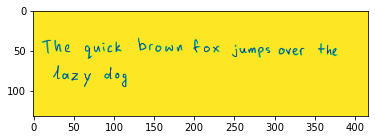

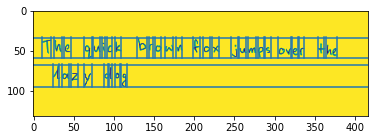

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("Untitled_Artwork.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
plt.show()

# Detect left and right edges of alphabets
edges = cv2.Canny(img,100,200)
horizontal_sum = np.sum(edges, axis = 1)
horizontal_sum = horizontal_sum != 0
horizontal_changes = np.logical_xor(horizontal_sum[1:], horizontal_sum[:-1])
horizontal_change_pts = np.nonzero(horizontal_changes)[0]

# Detect top and bottom edges of each row of words
vertical_change_pts = {}
for i in range(0, len(horizontal_change_pts), 2):
    start, end = horizontal_change_pts[i], horizontal_change_pts[i + 1]
    vertical_sum = np.sum(edges[start:end], axis = 0)
    vertical_sum = vertical_sum != 0
    vertical_changes = np.logical_xor(vertical_sum[1:], vertical_sum[:-1])
    vertical_change_pts[start] = (start, end, np.nonzero(vertical_changes)[0])

plt.imshow(img)
for change in horizontal_change_pts:
    plt.axhline(change)
for line in vertical_change_pts:
    for change in vertical_change_pts[line][2]:
        plt.axvline(change, 1- vertical_change_pts[line][0]/img.shape[0], 1- vertical_change_pts[line][1]/img.shape[0])
plt.show()

#### Detect contours of each alphabet and obtain their bounding box coordinates
The following code finds the bounding box for each alphabet that will be grouped together to form words after prediction. The variable "close_dist" define the distance between alphabets to determine if they belong to the same word.

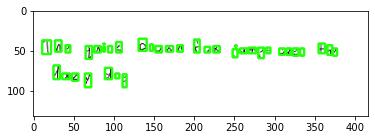

In [2]:
image = cv2.imread('Untitled_Artwork.png')
original = image.copy()
grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(grey, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Find contours, obtain bounding boxes
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

boxes = []
close_dist = 8
for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    
    # x1, y1 coordinates of bottom left, x2, y2 coordinates of top right
    x1, y1, x2, y2 = max(0, x), min(image.shape[0], y+h), min(image.shape[1], x+w), max(0,y)
    boxes.append([x1, y1, x2, y2])
boxes.sort(key = lambda x:x[3])

for box in boxes:
    cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (36,255,12), 2)   
plt.imshow(image)

In [3]:
# Function to check if two bounding boxes are overlapping
def isRectangleOverlap(rec1, rec2):
    return not (rec1[2] <= rec2[0] or  # left
                    rec1[3] >= rec2[1] or  # bottom
                    rec1[0] >= rec2[2] or  # right
                    rec1[1] <= rec2[3])    # top

# Function to assign individual bounding boxes to their respective row number
def binY(horizontal_change_pts, boxes):
    bins, ind = [], 0
    for i in range(0, len(horizontal_change_pts), 2):
        j = i+1
        bins.append((ind, horizontal_change_pts[i], horizontal_change_pts[j]))
        ind += 1
    
    for i in range(len(boxes)):
        center = (boxes[i][1] + boxes[i][3]) // 2
        for j in range(len(bins)):
            if bins[j][1] <= center <= bins[j][2]:
                boxes[i].append(bins[j][0])
    boxes.sort(key = lambda x: (x[-1], x[0]))
    return bins, boxes

With the coordinate information of the bounding boxes the overlapping boxes can be grouped together to form word level bounding boxes. An additional step along the way would be to identify the dots from the "i" and "j" characters to group them into the same alphabet level bounding box for prediction.

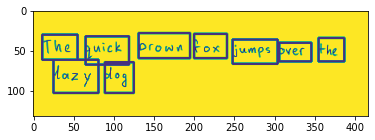

In [4]:
image = cv2.imread('Untitled_Artwork.png', cv2.IMREAD_GRAYSCALE)
single_bounding_boxes_filepath = 'single_bounding_boxes\\'

# Function to include the dots of i and j in the alphabet's bounding box
def combineIJdots(boxes):
    combined_boxes = []
    prev = boxes[0]
    for i, box in enumerate(boxes):
        coords, word_bin = box[:4], box[-1]
        overlap_coords = [max(0, coords[0]),
                          min(image.shape[0], coords[1] + 3),
                          min(image.shape[1], coords[2] + 1),
                          max(0, coords[3] - 3),
                          word_bin]
        box1 = prev
        box2 = overlap_coords
        overlap = isRectangleOverlap(prev, overlap_coords)
        if overlap:
            prev = [min(box1[0], box2[0]),
                    max(box1[1], box2[1]),
                    max(box1[2], box2[2]),
                    min(box1[3], box2[3]),
                    word_bin]
        else:
            combined_boxes.append(prev)
            prev = overlap_coords
    
    if overlap:
        combined_boxes.append(prev)
    else:
        combined_boxes.append(overlap_coords)
    
    return combined_boxes

# Function to combine bounding boxes at alphabet level to word level
def combineBoxes(boxes):
    combined_boxes = []
    file_paths = []
    word_count, curr_bin = 0, -1
    for i, box in enumerate(boxes):
        coords, word_bin = box[:4], box[-1]
        overlap_coords = [max(0, coords[0]),
                          min(image.shape[0], coords[1] + close_dist//2),
                          min(image.shape[1], coords[2] + close_dist),
                          max(0, coords[3] - close_dist//2),
                          word_count]
        if curr_bin < word_bin:
            combined_boxes.append(overlap_coords)
            word_count += 1
            curr_bin += 1
        else:
            box1 = combined_boxes[word_count-1]
            box2 = overlap_coords
            overlap = isRectangleOverlap(box1, box2)
            if overlap:
                combined_boxes[word_count - 1] = [min(box1[0], box2[0]),
                                     max(box1[1], box2[1]),
                                     max(box1[2], box2[2]),
                                     min(box1[3], box2[3]),
                                     word_count]
            else:
                combined_boxes.append(overlap_coords)
                word_count += 1
                
        # Save images from individual bounding boxes
        boundaries = image[coords[3]:coords[1], coords[0]:coords[2]]
        single_file_path = str(single_bounding_boxes_filepath) + 'ROI_' + str(i) + '_' + str(word_count) + '.png'
        padded_image = cv2.copyMakeBorder(boundaries, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value = 255)
        cv2.imwrite(os.getcwd() + '\\' + single_file_path, padded_image)
        #cv2.imwrite(os.getcwd() + '\\' + single_file_path, boundaries)
        file_paths.append((word_count, single_file_path))
        
    return combined_boxes, file_paths


bins, boxes = binY(horizontal_change_pts, boxes)
boxes = combineIJdots(boxes)
combined_boxes, file_paths = combineBoxes(boxes)

image = cv2.imread('Untitled_Artwork.png', cv2.IMREAD_GRAYSCALE)
for box in combined_boxes:
    cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (36,255,12), 2) 
plt.imshow(image)

***

<a id = '3'></a>
## 3. Image Recognition
For image recognition we will be using [this dataset](https://www.kaggle.com/dhruvildave/english-handwritten-characters-dataset) from Kaggle to build a CNN that will predict for individual alphabets.

In [5]:
import pandas as pd
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation
from keras import optimizers
from keras.models import save_model, load_model

# Variables
train_ = 0.95
validation_ = 0.05

batch_size = 32
image_width = 128
image_height = 128
img_size = (image_height, image_width)

np.random.seed(33)
tf.random.set_seed(33)

epochs = 100

In [6]:
# Read Dataset
base_dir = os.getcwd()
base_path = base_dir + '\\data'
df = pd.read_csv(base_dir + "\\data\\english.csv")
print("Before \n",df.head())
df = df.loc[df['label'] >= 'A'] # Exclude numerical characters, keep only A-Z and a-z
print("After \n",df.head())

Before 
                 image label
0  Img/img001-001.png     0
1  Img/img001-002.png     0
2  Img/img001-003.png     0
3  Img/img001-004.png     0
4  Img/img001-005.png     0
After 
                   image label
550  Img/img011-001.png     A
551  Img/img011-002.png     A
552  Img/img011-003.png     A
553  Img/img011-004.png     A
554  Img/img011-005.png     A


In [7]:
unique_labels = len(df.label.unique())
image_path = base_dir + base_path + '\\Img'

training_samples = df.groupby('label').apply(lambda s: s.sample(int(len(s) * train_)))
validation_samples = df[~df.image.isin(training_samples.image)]
print(f"Number of Training Samples found : {len(training_samples)}" )
print(f"Number of Validation Samples found : {len(validation_samples)}" )

Number of Training Samples found : 2704
Number of Validation Samples found : 156


In [8]:
# Image generator
train_data_generator = ImageDataGenerator(
            rescale=1/255,
            shear_range=0.1,
            zoom_range=0.1,
            width_shift_range=0.1,
            height_shift_range=0.1,)
data_generator = ImageDataGenerator(rescale = 1/255)

training_data_frame = train_data_generator.flow_from_dataframe( 
                                            dataframe = training_samples, 
                                            directory = base_path,
                                            x_col = 'image',
                                            y_col = 'label',
                                            target_size = img_size,
                                            class_mode = 'categorical')
validation_data_frame = data_generator.flow_from_dataframe( 
                                            dataframe = validation_samples, 
                                            directory = base_path,
                                            x_col = 'image',
                                            y_col = 'label',
                                            target_size = img_size,
                                            class_mode = 'categorical')

Found 2704 validated image filenames belonging to 52 classes.
Found 156 validated image filenames belonging to 52 classes.


In [9]:
# Building the model

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same', input_shape = [image_height,image_width,3]))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(unique_labels, activation = 'softmax'))

opt = optimizers.Adam(epsilon = 0.01)
model.compile(
            optimizer=opt,
            loss= 'categorical_crossentropy',
            metrics = ['accuracy'])

In [10]:
#Training
history = model.fit(training_data_frame, validation_data = validation_data_frame, 
                    steps_per_epoch = len(training_samples)//32 + 1,
                    epochs = epochs,
                    validation_steps = len(validation_samples)//32 + 1,
                    verbose = 1
                )

Epoch 1/100
85/85 [==============================] - 62s 514ms/step - loss: 3.9812 - accuracy: 0.0201 - val_loss: 3.9530 - val_accuracy: 0.0000e+00
Epoch 2/100
85/85 [==============================] - 31s 373ms/step - loss: 3.9511 - accuracy: 0.0179 - val_loss: 3.9500 - val_accuracy: 0.0256
Epoch 3/100
85/85 [==============================] - 31s 372ms/step - loss: 3.9519 - accuracy: 0.0164 - val_loss: 3.9459 - val_accuracy: 0.0192
Epoch 4/100
85/85 [==============================] - 31s 369ms/step - loss: 3.9472 - accuracy: 0.0275 - val_loss: 3.9379 - val_accuracy: 0.0449
Epoch 5/100
85/85 [==============================] - 31s 370ms/step - loss: 3.9364 - accuracy: 0.0321 - val_loss: 3.8607 - val_accuracy: 0.0321
Epoch 6/100
85/85 [==============================] - 31s 373ms/step - loss: 3.8452 - accuracy: 0.0472 - val_loss: 3.4647 - val_accuracy: 0.1410
Epoch 7/100
85/85 [==============================] - 31s 373ms/step - loss: 3.6368 - accuracy: 0.1057 - val_loss: 3.0245 - val_accur

85/85 [==============================] - 30s 351ms/step - loss: 0.5253 - accuracy: 0.8206 - val_loss: 0.4306 - val_accuracy: 0.8782
Epoch 58/100
85/85 [==============================] - 30s 357ms/step - loss: 0.5299 - accuracy: 0.8313 - val_loss: 0.6592 - val_accuracy: 0.8397
Epoch 59/100
85/85 [==============================] - 32s 377ms/step - loss: 0.5397 - accuracy: 0.8088 - val_loss: 0.4327 - val_accuracy: 0.8526
Epoch 60/100
85/85 [==============================] - 32s 376ms/step - loss: 0.5217 - accuracy: 0.8294 - val_loss: 0.4744 - val_accuracy: 0.8462
Epoch 61/100
85/85 [==============================] - 31s 374ms/step - loss: 0.5387 - accuracy: 0.8261 - val_loss: 0.4410 - val_accuracy: 0.8718
Epoch 62/100
85/85 [==============================] - 32s 378ms/step - loss: 0.4848 - accuracy: 0.8387 - val_loss: 0.4461 - val_accuracy: 0.9038
Epoch 63/100
85/85 [==============================] - 31s 374ms/step - loss: 0.5062 - accuracy: 0.8307 - val_loss: 0.5446 - val_accuracy: 0.891

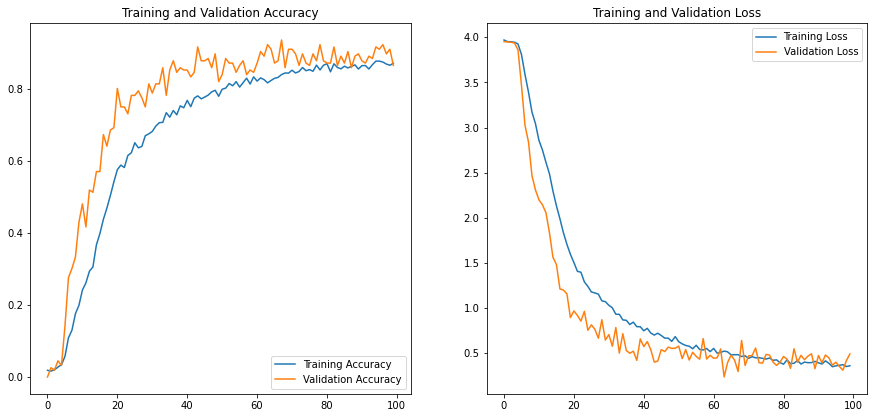

In [11]:
#Evaluation
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Model saving
model.save('handwriting_recognition.h5')

During the training phase we observe approximately 85~90% validation accuracy, suggesting that the model will likely misclassify at least one alphabet in most words which may reduce the effectiveness of the model.

#### Predicting words within an image
Next we shall see how well the prediction works on the image seen in Section 2 of this notebook

In [12]:
pred_df = pd.DataFrame(file_paths, columns = ['word', 'fp'])
pred_df['fake_class'] = '0'

base_dir = os.getcwd()
base_path = base_dir
pred_data_frame = data_generator.flow_from_dataframe( 
                                            dataframe = pred_df, 
                                            directory = base_path,
                                            x_col = 'fp',
                                            y_col = 'fake_class',
                                            target_size = img_size,
                                            class_mode = 'categorical',
                                            shuffle = False)

model = load_model('handwriting_recognition.h5')

pred = model.predict(pred_data_frame, steps = len(file_paths)//32 + 1)
pred_classes = pred.argmax(axis = 1)
pred_df['prediction'] = pred_classes
pred_df.head()

Found 35 validated image filenames belonging to 1 classes.


,word,fp,fake_class,prediction
0,1,single_bounding_boxes\ROI_0_1.png,0,19
1,1,single_bounding_boxes\ROI_1_1.png,0,33
2,1,single_bounding_boxes\ROI_2_1.png,0,28
3,2,single_bounding_boxes\ROI_3_2.png,0,8
4,2,single_bounding_boxes\ROI_4_2.png,0,46


In [13]:
# Convert numerical label to alphabets
classDict = training_data_frame.class_indices
classDict = dict((v, k) for k, v in classDict.items())

pred_df['predicted_labels'] = pred_classes
pred_df['predicted_labels'] = pred_df['predicted_labels'].replace(classDict)

output = []
curr_word = 1
word = ''
for ind, row in pred_df.iterrows():
    if row['word'] == curr_word:
        word += row['predicted_labels']
    else:
        output.append(word)
        curr_word = row['word']
        word = row['predicted_labels']
output.append(word)
output

['Thc', 'Iuick', 'Lrcwn', 'ccx', 'JunTc', 'cxcT', 'thc', 'icIx', 'dcS']

To tackle the misclassified alphabets we shall try using a spellchecker on our predictions.

In [14]:
# Use a spellchecker
from spellchecker import SpellChecker
english = SpellChecker()

output_corrected = []
for word in output:
    word = word.lower()
    output_corrected.append(english.correction(word))
output_corrected

['the', 'quick', 'grown', 'cox', 'junta', 'cut', 'the', 'ici', 'des']

***

<a id = '4'></a>
## 4. Deployment
For deployment we will create a web application using Flask in a form of webpage that returns the predictions after taking in an uploaded image file.

```python
from flask import Flask, flash, render_template, url_for, request, redirect
import urllib.request
import os
from werkzeug.utils import secure_filename

# import function to make prediction (Code from sections 2 and 3 of this notebook)
from recognition import make_prediction

UPLOAD_FOLDER = 'static/uploads/'

app = Flask(__name__)
app.secret_key = 'handwriting'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
prediction = None

# Check file extensions to verify image file
ALLOWED_EXTENSIONS = set(['png', 'jpg', 'jpeg', 'gif'])
def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS


@app.route('/')
def home():
    return render_template('home.html')

@app.route('/', methods = ['POST'])
def upload_image():    
    if 'file' not in request.files:
        flash('No file part')
        return redirect(request.url)
    file = request.files['file']
    if file.filename == '':
        flash('No image selected for uploading')
        return redirect(request.url)
    if file and allowed_file(file.filename):        
        filename = secure_filename(file.filename)
        file.save(os.path.join(app.config['UPLOAD_FOLDER'], filename))
        #print('upload_image filename: ' + filename)
        flash('Image successfully uploaded and displayed below')
        
        img_path = UPLOAD_FOLDER + filename
        
        prediction = make_prediction(img_path)
        
        return render_template('home.html', filename=filename, prediction = prediction)
    else:
        flash('Allowed image types are - png, jpg, jpeg, gif')
        return redirect(request.url)

@app.route('/display/<filename>')
def display_image(filename):
    #print('display_image filename: ' + filename)
    return redirect(url_for('static', filename='uploads/' + filename), code=301)

if __name__ == "__main__":
    app.run()
```

The following shows the default home page of the web application.
<img src='deployment1.png'>

After selected an image file to upload and pressing "Submit" predictions will be made and returned in the following page
<img src='deployment2.png'>

***

<a id = '5'></a>
## 5. Final Thoughts
In this notebook I have created a basic web application that reads and predicts words in an uploaded image. Looking at the final results we observe that there are multiple mistakes in the translation of "The quick brown fox jumps over the lazy dog".

The main limitation of this model leading to these mistakes is mainly the relatively small training data used for model training (~3000 images for 52 alphabets). During training the validation accuracy of the model was observed to be approximately 80% which is relatively low for a model created to simple recognise alphabets.

By training the model on a larger dataset with more diverse examples of how each alphabet can be written the model should perform significantly better as the assumptions made for this model trivialises some of the problems faced in OCR.

Just for fun, here are some other pangrams that I've tried to run the model on
<img src = 'deployment3.png'>